In [124]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector

In [125]:
# Connect to the MySQL database

db = mysql.connector.connect(host = 'localhost',
                            username = 'root',
                            password = '1234', 
                            database = 'ecommerce_sales')

cur = db.cursor()

# 1. List all unique cities where customers are located 

In [126]:
query = ''' 
            SELECT DISTINCT customer_city 
            FROM customers
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['City'])
df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of orders placed in 2017

In [127]:
query = ''' 
            SELECT COUNT(order_id) 
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2017;
        '''

cur.execute(query)

data = cur.fetchall()

'Total orders placed in 2017 are:', data[0][0]

('Total orders placed in 2017 are:', 45101)

# 3. Find the total sales per category.

In [128]:
query = ''' 
            SELECT UPPER(products.product_category), 
                   ROUND(SUM(payments.payment_value), 2) AS Total_sales
            FROM products 
            JOIN order_items ON products.product_id = order_items.product_id
            JOIN payments ON order_items.order_id = payments.order_id
            GROUP BY products.product_category
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Total_Sales'])
df

,Category,Total_Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments

In [129]:
query = ''' 
            SELECT (SUM(CASE WHEN payment_installments > 1 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS Installments_Percentage 
            FROM payments  
        '''

cur.execute(query)

data = cur.fetchall()

'Installments_Percentage:', data[0][0]

('Installments_Percentage:', Decimal('49.4176'))

# 5. Count the number of customers from each state

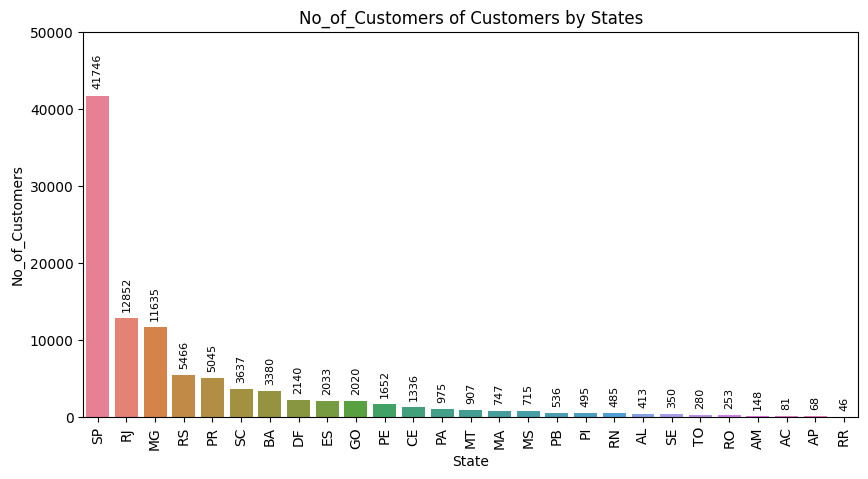

In [130]:
query = ''' 
            SELECT customer_state, 
                   COUNT(customer_id) AS No_of_Customers
            FROM customers
            GROUP BY customer_state
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['State', 'No_of_Customers'])
df = df.sort_values(by = 'No_of_Customers', ascending = False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x='State', y='No_of_Customers', hue='State', data=df)
plt.title('No_of_Customers of Customers by States')
plt.ylim(0, 50000) 
plt.xticks(rotation = 90)

max_height = max([p.get_height() for p in ax.patches])  # Get the max height
# Add labels on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.02 * max_height, 
            '{:.0f}'.format(p.get_height()), ha='center', va='bottom',
            rotation=90, fontsize=8)
plt.show()

# 6. Calculate the number of orders per month in 2018

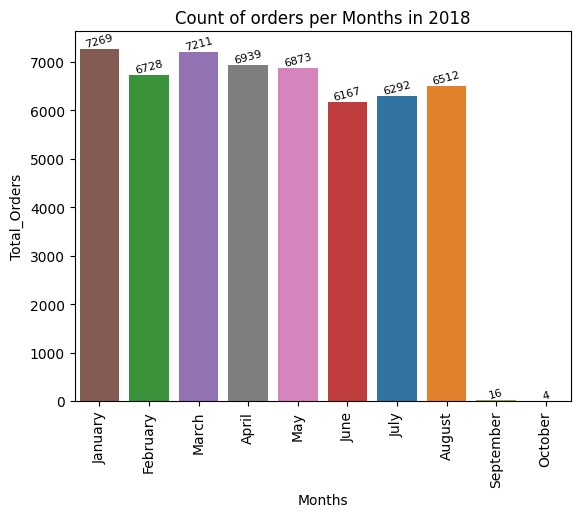

In [131]:
query = ''' 
            SELECT MONTHNAME(order_purchase_timestamp) AS Months, 
                   COUNT(order_id) AS Total_Orders
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2018
            GROUP BY Months
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Months','Total_Orders'])
O = ['January','February','March','April','May','June','July','August','September','October']

ax = sns.barplot(x=df['Months'],y=df['Total_Orders'],hue=df['Months'],data=df,order=O)
plt.title('Count of orders per Months in 2018')
plt.xticks(rotation=90)

# Add labels on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, 
            '{:.0f}'.format(p.get_height()), ha='center', va='bottom',
            rotation=15, fontsize=8)

plt.show()

# 7. Find the average number of products per order, grouped by customer city

In [132]:
query = ''' 
            WITH count_per_order AS (
                SELECT orders.order_id, 
                       orders.customer_id, 
                       COUNT(order_items.product_id) AS order_count
                FROM orders 
                JOIN order_items ON orders.order_id = order_items.order_id
                GROUP BY orders.order_id, orders.customer_id
            )
            SELECT customers.customer_city, 
                   ROUND(AVG(count_per_order.order_count), 2) AS Avg_order
            FROM customers 
            JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
            GROUP BY customers.customer_city
            ORDER BY Avg_order DESC
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_City', 'Avg_Order'])
df

,Customer_City,Avg_Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sebastiao leal,1.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# 8. Calculate the percentage of total revenue contributed by each product category

In [133]:
query = ''' 
            SELECT UPPER(products.product_category), 
                   ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS Total_Revenue_Percentage
            FROM products 
            JOIN order_items ON products.product_id = order_items.product_id
            JOIN payments ON order_items.order_id = payments.order_id
            GROUP BY products.product_category
            ORDER BY Total_Revenue_Percentage DESC 
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Product_Category', 'Total_Revenue_Percentage'])
df

,Product_Category,Total_Revenue_Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# 9. Identify the correlation between product price and the number of times a product has been purchased

In [134]:
query = ''' 
            SELECT UPPER(products.product_category), 
                   COUNT(order_items.product_id) AS Product_count, 
                   ROUND(AVG(order_items.price), 2) AS Avg_Price
            FROM products 
            JOIN order_items ON products.product_id = order_items.product_id
            GROUP BY products.product_category
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Product_Category', 'Product_count', 'Avg_Price'])

arr1 = df['Product_count']
arr2 = df['Avg_Price']
correlation = np.corrcoef([arr1,arr2])

print('The correlation between product price and the number of times a product has been purchased is:', correlation[0][1])

The correlation between product price and the number of times a product has been purchased is: -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue

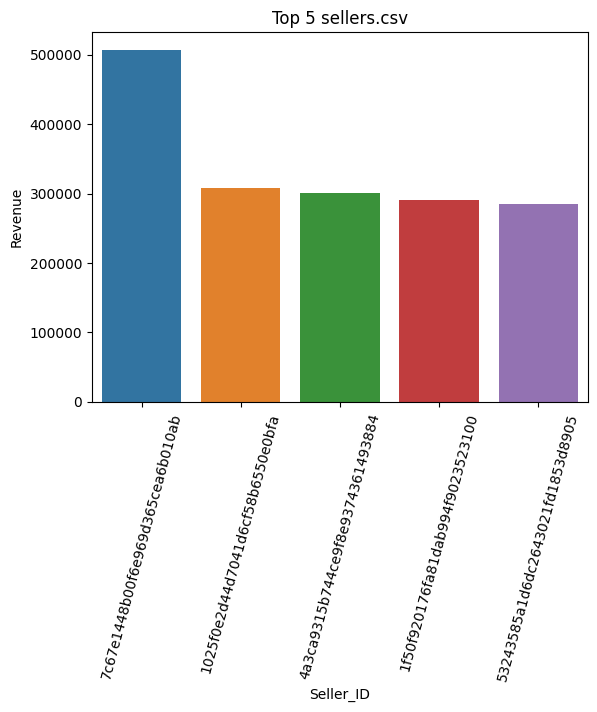

,Seller_ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


In [135]:
query = ''' 
            SELECT *,
                   DENSE_RANK() OVER (ORDER BY Revenue DESC) AS Rank_
            FROM (
                SELECT order_items.seller_id,
                       ROUND(SUM(payments.payment_value), 2) AS Revenue
                FROM order_items
                JOIN payments ON order_items.order_id = payments.order_id
                GROUP BY order_items.seller_id
            ) AS Rk
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Seller_ID', 'Revenue', 'Rank'])

df_graph = df.head()

ax = sns.barplot(x='Seller_ID',y='Revenue',hue='Seller_ID',data=df_graph) 
plt.title('Top 5 sellers.csv')
plt.xticks(rotation=75)
plt.show()

df

# 11. Calculate the moving average of order values for each customer over their order history

In [136]:
query = ''' 
            SELECT *, 
                   AVG(payment) OVER (
                       PARTITION BY customer_id 
                       ORDER BY order_purchase_timestamp 
                       ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
                   ) AS Moving_Average 
            FROM (
                SELECT 
                    orders.customer_id, 
                    orders.order_purchase_timestamp, 
                    payments.payment_value AS payment
                FROM 
                    orders 
                JOIN 
                    payments ON orders.order_id = payments.order_id
            ) AS cus_history 
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_ID', 'Order_Purchase_Timestamp', 'Payment', 'Moving_Average'])

df

,Customer_ID,Order_Purchase_Timestamp,Payment,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year

In [137]:
query = ''' 
            SELECT *, 
                   ROUND(SUM(payment) OVER(ORDER BY years, months), 2) AS cumulative_sales
            FROM (
                SELECT YEAR(orders.order_purchase_timestamp) AS years, 
                       MONTH(orders.order_purchase_timestamp) AS months, 
                       ROUND(SUM(payments.payment_value), 2) AS payment
                FROM orders 
                JOIN payments ON orders.order_id = payments.order_id
                GROUP BY years, months 
                ORDER BY years, months
            ) AS pay_details
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years', 'Months', 'Payment', 'Cumulative_Sales'])

df

,Years,Months,Payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales

In [138]:
query = ''' 
            WITH pay_year AS (
                SELECT 
                    YEAR(orders.order_purchase_timestamp) AS years, 
                    ROUND(SUM(payments.payment_value), 2) AS payment
                FROM 
                    orders 
                JOIN 
                    payments ON orders.order_id = payments.order_id
                GROUP BY 
                    years 
                ORDER BY 
                    years
            )
            SELECT 
                years, 
                ((payment - LAG(payment, 1) OVER(ORDER BY years)) / LAG(payment, 1) OVER(ORDER BY years)) * 100 AS year_growth
            FROM 
                pay_year
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years', 'Year_%_Growth'])

df

,Years,Year_%_Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [139]:
query = ''' 
            WITH f_date AS (
                SELECT 
                    customers.customer_id, 
                    MIN(orders.order_purchase_timestamp) AS first_order
                FROM 
                    customers 
                JOIN 
                    orders ON customers.customer_id = orders.customer_id
                GROUP BY 
                    customers.customer_id
            ),
            
            sec_date AS (
                SELECT 
                    f_date.customer_id, 
                    COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
                FROM 
                    f_date 
                JOIN 
                    orders ON f_date.customer_id = orders.customer_id
                AND 
                    orders.order_purchase_timestamp > first_order
                AND 
                    orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
                GROUP BY 
                    f_date.customer_id
            )
            
            SELECT 
                100 * (COUNT(DISTINCT f_date.customer_id) / COUNT(DISTINCT sec_date.customer_id)) AS Retention_Rate_of_Customers
            FROM 
                f_date 
            LEFT JOIN 
                sec_date ON f_date.customer_id = sec_date.customer_id;
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Retention_Rate_of_Customers'])

df

,Retention_Rate_of_Customers
0,None


In this dataset, customers may purchase a product multiple times on the same day, but they do not make any purchases after the first day of purchase. As a result, the Retention Rate for customers is zero.

# 15. Identify the top 3 customers who spent the most money in each year

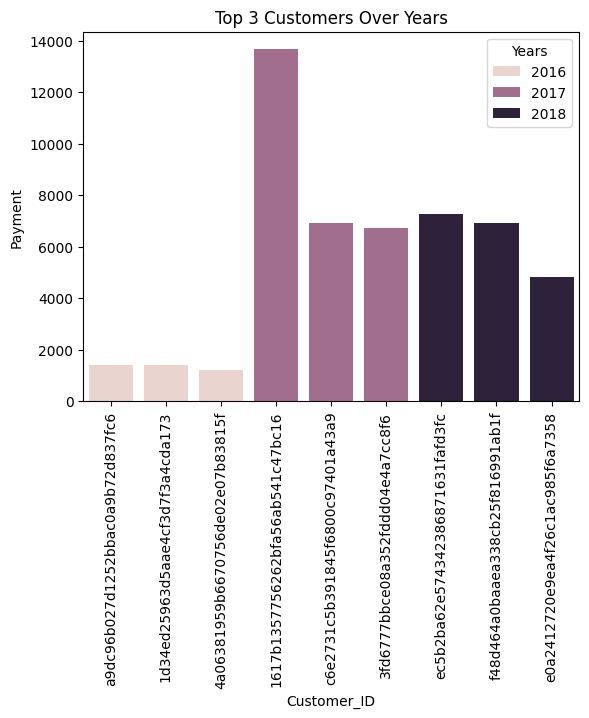

In [140]:
query = ''' 
            SELECT years, customer_id, payment, ranking
            FROM (
                SELECT 
                    YEAR(orders.order_purchase_timestamp) AS years, 
                    orders.customer_id, 
                    ROUND(SUM(payments.payment_value), 2) AS payment,
                    DENSE_RANK() OVER (
                        PARTITION BY YEAR(orders.order_purchase_timestamp) 
                        ORDER BY SUM(payments.payment_value) DESC
                    ) AS ranking
                FROM orders
                JOIN payments ON orders.order_id = payments.order_id
                GROUP BY years, orders.customer_id
            ) AS rank_table
            WHERE ranking <= 3;
        '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years', 'Customer_ID', 'Payment', 'Ranking'])

ax = sns.barplot(x='Customer_ID',y='Payment',hue='Years',data=df)
plt.title('Top 3 Customers Over Years')
plt.xticks(rotation=90)
plt.show()